# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [3]:
test = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
test.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [4]:
print('Shape of train data:', train.shape)
print('Shape of test data:', test.shape)

Shape of train data: (20000, 22)
Shape of test data: (5000, 21)


# **Exploratory data analysis (EDA)**

In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [6]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               5000 non-null   object 
 1   Cross_Street           810 non-null    object 
 2   Latitude               5000 non-null   float64
 3   Longitude              5000 non-null   float64
 4   Date_Reported          5000 non-null   object 
 5   Date_Occurred          5000 non-null   object 
 6   Time_Occurred          5000 non-null   float64
 7   Area_ID                5000 non-null   float64
 8   Area_Name              5000 non-null   object 
 9   Reporting_District_no  5000 non-null   float64
 10  Part 1-2               5000 non-null   float64
 11  Modus_Operandi         4316 non-null   object 
 12  Victim_Age             5000 non-null   float64
 13  Victim_Sex             4357 non-null   object 
 14  Victim_Descent         4357 non-null   object 
 15  Prem

In [7]:
print(train.describe())

           Latitude     Longitude  Time_Occurred       Area_ID  \
count  20000.000000  20000.000000   20000.000000  20000.000000   
mean      33.940704   -117.893072    1352.380350     10.834250   
std        2.126810      7.377726     646.100291      6.033166   
min        0.000000   -118.663400       1.000000      1.000000   
25%       34.009200   -118.429700     930.000000      6.000000   
50%       34.058700   -118.323000    1430.000000     11.000000   
75%       34.165025   -118.274400    1900.000000     16.000000   
max       34.328100      0.000000    2359.000000     21.000000   

       Reporting_District_no      Part 1-2    Victim_Age  Premise_Code  \
count           20000.000000  20000.000000  20000.000000  20000.000000   
mean             1129.599200      1.418150     30.135000    297.176950   
std               603.330519      0.493267     21.863645    212.007298   
min               101.000000      1.000000     -2.000000    101.000000   
25%               632.000000      1

# **CONCLUSION**

**Some fields, like Latitude, Longitude, and Victim_Age, contain potentially missing data.**

**There is significant missing data in the Weapon_Used_Code field, with only about a third of the entries having this information recorded.**

In [8]:
print('Train data null values:')
print(train.isnull().sum())
print('Test data null values:')
print(test.isnull().sum())

Train data null values:
Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64
Test data null values:
Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name         

In [9]:
print('Data type in train data:')
print(train.dtypes)
print()
print()
print('Data type in test data:')
print(test.dtypes)

Data type in train data:
Location                  object
Cross_Street              object
Latitude                 float64
Longitude                float64
Date_Reported             object
Date_Occurred             object
Time_Occurred            float64
Area_ID                  float64
Area_Name                 object
Reporting_District_no    float64
Part 1-2                 float64
Modus_Operandi            object
Victim_Age               float64
Victim_Sex                object
Victim_Descent            object
Premise_Code             float64
Premise_Description       object
Weapon_Used_Code         float64
Weapon_Description        object
Status                    object
Status_Description        object
Crime_Category            object
dtype: object


Data type in test data:
Location                  object
Cross_Street              object
Latitude                 float64
Longitude                float64
Date_Reported             object
Date_Occurred             object
Time_Occurr

In [10]:
print('Train data duplicate values:')
print(train.duplicated().sum())
print('Test data duplicate values:')
print(test.duplicated().sum())


Train data duplicate values:
13
Test data duplicate values:
3


In [11]:
train.drop_duplicates(inplace=True)

In [12]:
train.shape

(19987, 22)

# **Feature Engineering**

In [13]:
date_format = '%m/%d/%Y %I:%M:%S %p'  # Month/Day/Year Hour:Minute:Second AM/PM

train['Date_Reported'] = pd.to_datetime(train['Date_Reported'], format=date_format)
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'], format=date_format)

train['Year_Reported'] = train['Date_Reported'].dt.year
train['Month_Reported'] = train['Date_Reported'].dt.month
train['Day_Reported'] = train['Date_Reported'].dt.day
train['Hour_Occurred'] = train['Time_Occurred'].apply(lambda x: int(x // 100))

test['Date_Reported'] = pd.to_datetime(test['Date_Reported'], format=date_format)
test['Date_Occurred'] = pd.to_datetime(test['Date_Occurred'], format=date_format)

test['Year_Reported'] = test['Date_Reported'].dt.year
test['Month_Reported'] = test['Date_Reported'].dt.month
test['Day_Reported'] = test['Date_Reported'].dt.day
test['Hour_Occurred'] = test['Time_Occurred'].apply(lambda x: int(x // 100))

In [14]:
train['Cross_Street'] = train['Cross_Street'].fillna('Unknown')
train['Modus_Operandi'] = train['Modus_Operandi'].fillna('Unknown')
train['Victim_Sex'] = train['Victim_Sex'].fillna('Unknown')
train['Victim_Descent'] = train['Victim_Descent'].fillna('Unknown')
train['Premise_Description'] = train['Premise_Description'].fillna('Unknown')
train['Weapon_Description'] = train['Weapon_Description'].fillna('Unknown')

test['Cross_Street'] = test['Cross_Street'].fillna('Unknown')
test['Modus_Operandi'] = test['Modus_Operandi'].fillna('Unknown')
test['Victim_Sex'] = test['Victim_Sex'].fillna('Unknown')
test['Victim_Descent'] = test['Victim_Descent'].fillna('Unknown')
test['Premise_Description'] = test['Premise_Description'].fillna('Unknown')
test['Weapon_Description'] = test['Weapon_Description'].fillna('Unknown')

# **Data Preprocessing**

In [15]:
# Pipeline for numerical column with 'mean' strategy
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Pipeline for categorical columns with 'most_frequent' strategy for 'Unknown' values
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values = 'Unknown', strategy='most_frequent'))
])

num_cols = ['Weapon_Used_Code']
for column in num_cols:
    # Convert the column to 2D array explicitly
    train[[column]] = num_pipeline.fit_transform(train[[column]])
    test[[column]] = num_pipeline.transform(test[[column]])

# Apply the pipeline to the other columns
cat_cols = ['Cross_Street', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Premise_Description', 'Weapon_Description']

for column in cat_cols:
    # Convert the column to 2D array explicitly
    train[[column]] = cat_pipeline.fit_transform(train[[column]])
    test[[column]] = cat_pipeline.transform(test[[column]])

In [16]:
cat_encoder=LabelEncoder()
num_encoder=StandardScaler()

num_col = ['Latitude','Longitude', 'Time_Occurred', 'Area_ID','Reporting_District_no', 'Part 1-2', 'Victim_Age', 
                     'Premise_Code', 'Weapon_Used_Code']

cat_col = ['Location', 'Cross_Street','Date_Reported', 'Date_Occurred', 'Area_Name', 'Modus_Operandi', 
                           'Victim_Sex', 'Victim_Descent', 'Premise_Description','Weapon_Description',
                           'Status', 'Status_Description']

#encoding categorical columns
for col in cat_col:
    
    train[col]=cat_encoder.fit_transform(train[col].astype(str))
    test[col] = test[col].apply(lambda x: cat_encoder.transform([x])[0] if x in cat_encoder.classes_ else -1)
    
    
#encoding numerical columns
for col in num_col:
    
    train[col]=num_encoder.fit_transform(train[[col]])
    test[col] = num_encoder.fit_transform(test[[col]].astype(str))

# **Feature Extraction**

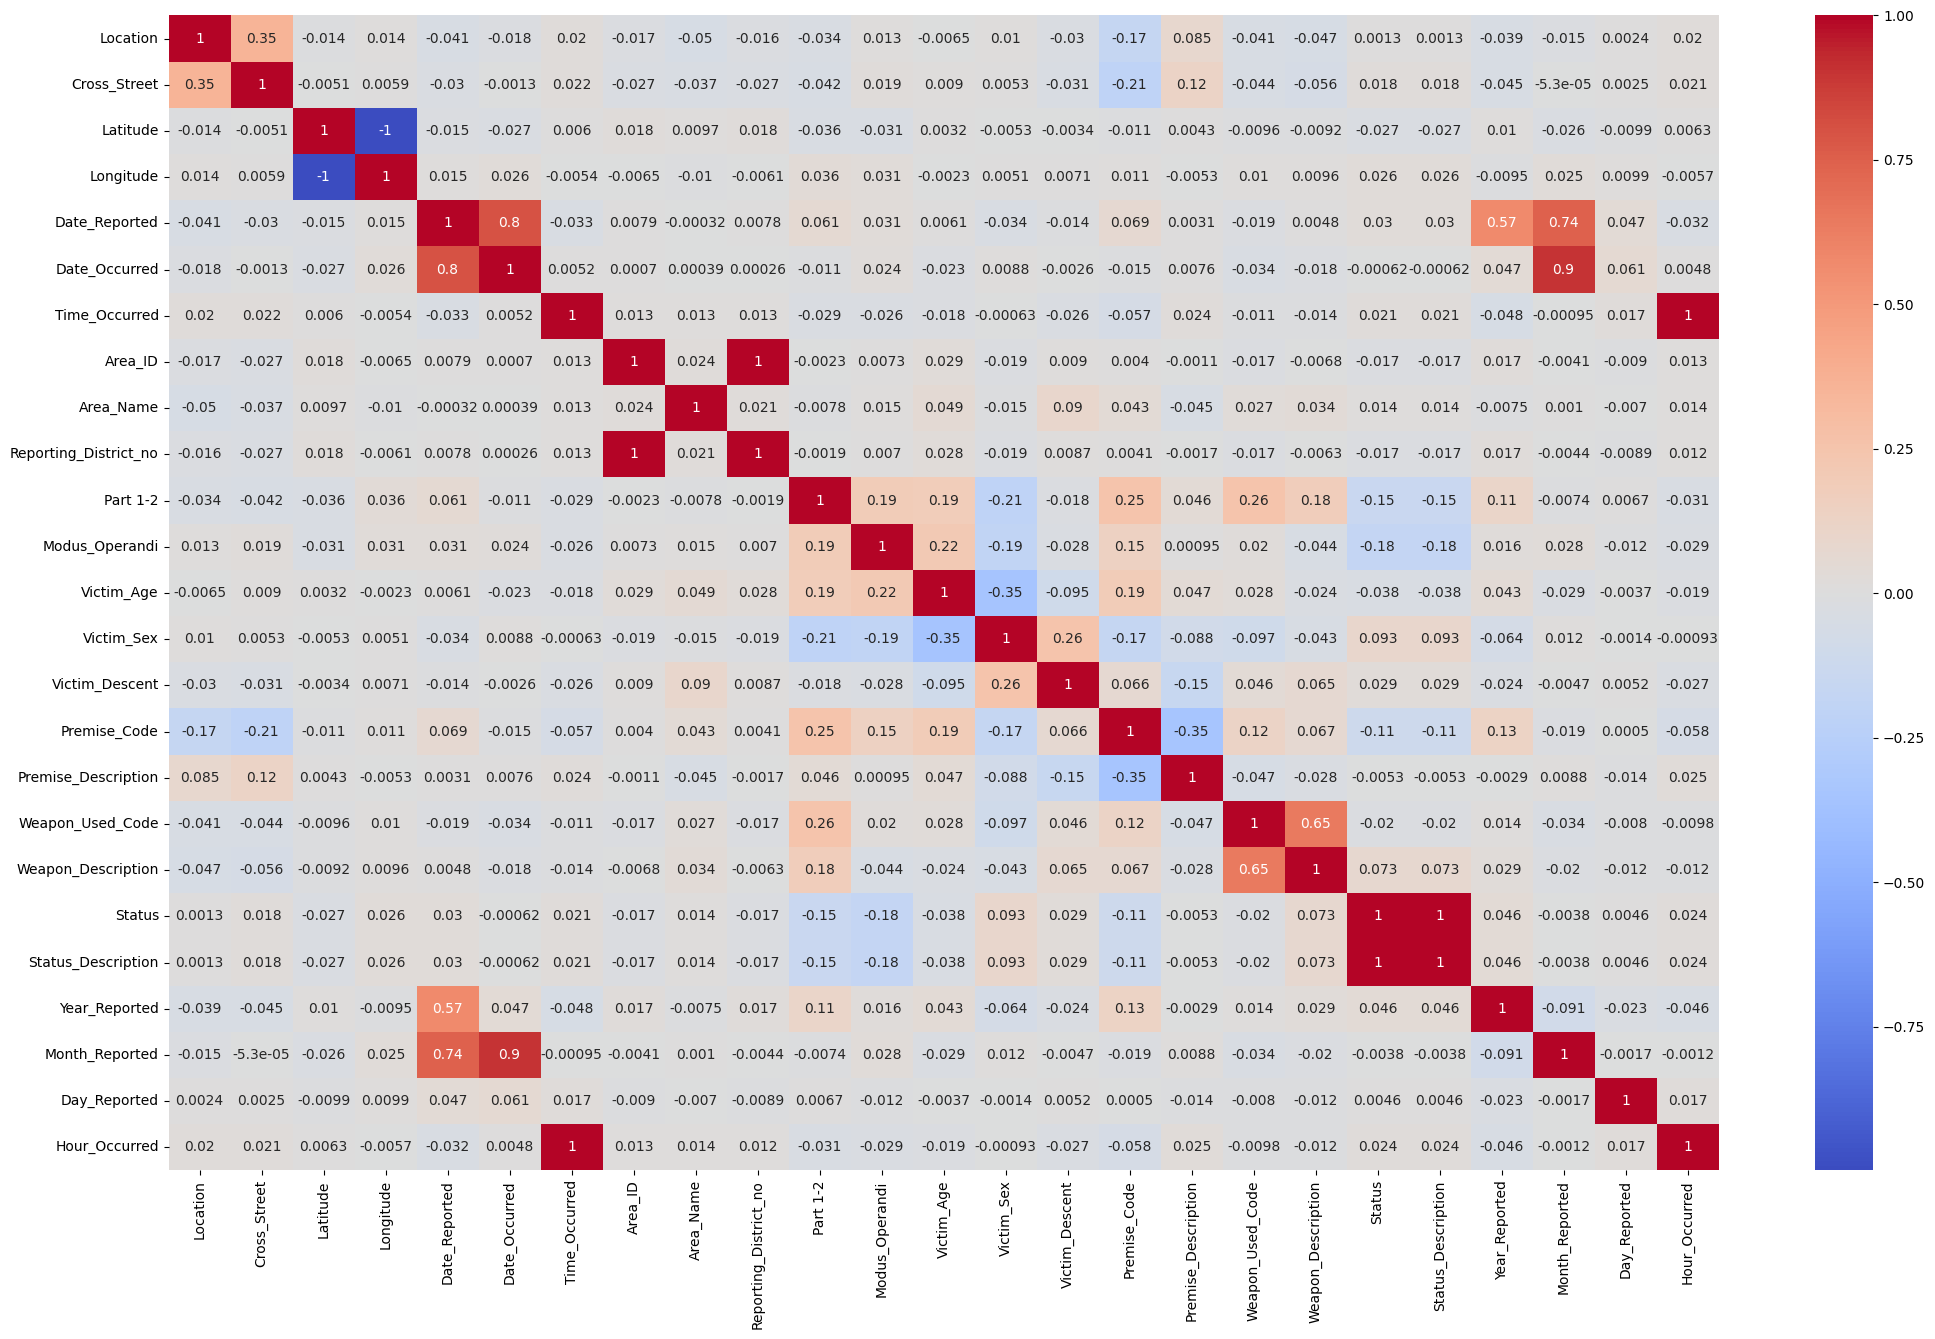

In [17]:
X_train_heat = train.drop(columns = ['Crime_Category'])
# Compute correlation matrix
correlation_matrix = X_train_heat.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [18]:
# # with Time_occured = 0.9792252346690808
# # without = 0.980
# X_train=train[['Latitude','Time_Occurred', 'Area_ID', 'Part 1-2', 'Victim_Age',
#               'Premise_Code', 'Weapon_Used_Code', 'Location','Cross_Street','Modus_Operandi', 
#               'Victim_Sex', 'Victim_Descent', 'Status']]
# Y_train=train['Crime_Category']

In [19]:
# test = test[['Latitude', 'Time_Occurred', 'Area_ID', 'Part 1-2', 'Victim_Age',
#               'Premise_Code', 'Weapon_Used_Code', 'Location','Cross_Street','Modus_Operandi', 
#               'Victim_Sex', 'Victim_Descent', 'Status']]

In [20]:
X_train = train.drop(columns = ['Longitude', 'Date_Reported', 'Date_Occurred',
                                'Area_Name', 'Reporting_District_no', 'Premise_Description',
                                'Weapon_Description', 'Status_Description', 'Crime_Category'])
Y_train=train['Crime_Category']

In [21]:
test = test.drop(columns = ['Longitude', 'Date_Reported', 'Date_Occurred',
                            'Area_Name', 'Reporting_District_no', 'Premise_Description',
                            'Weapon_Description', 'Status_Description'])

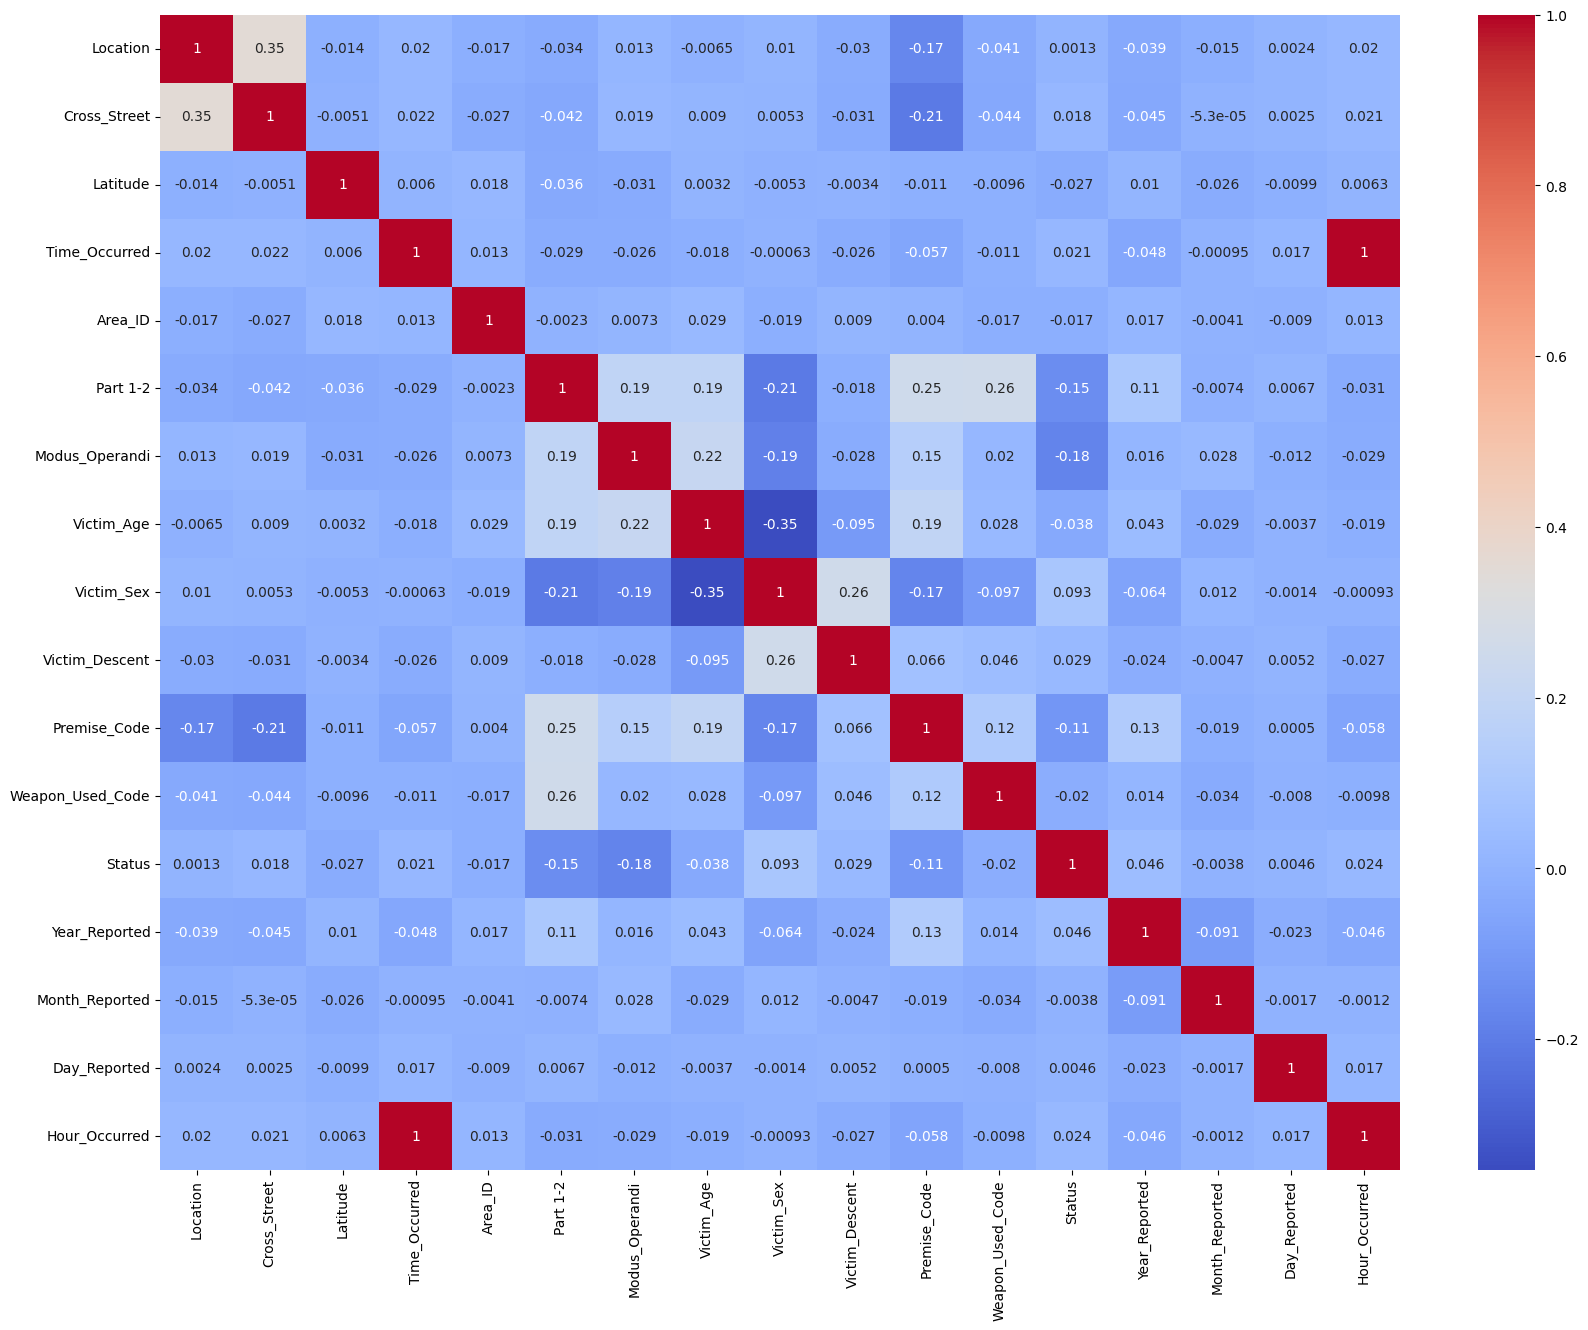

In [22]:
# Compute correlation matrix
correlation_matrix = X_train.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [23]:
ros = RandomOverSampler()
X,Y = ros.fit_resample(X_train,Y_train) 

# **Model Selection**

In [24]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.30, random_state=42)
x_train.shape,x_val.shape

((48967, 17), (20987, 17))

In [25]:
x_train.head()

,Location,Cross_Street,Latitude,Time_Occurred,Area_ID,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Year_Reported,Month_Reported,Day_Reported,Hour_Occurred
61370,12172,1286,0.053727,0.886359,-1.630173,1.179439,7034,-1.379165,2,14,-0.925413,-7.790440e-16,2,2020,6,1,19
2900,11690,1446,0.075208,-0.839697,-0.801365,-0.847861,2973,-0.006839,2,14,-0.925413,-8.543916e-01,1,2020,12,3,8
42799,6232,312,0.021905,-0.050201,0.193205,1.179439,32,0.038906,2,1,0.961454,-7.790440e-16,2,2022,5,24,13
15984,8340,312,0.075725,-0.206552,-0.801365,1.179439,4062,0.633580,0,14,1.947343,4.612968e-01,0,2020,7,20,12
16542,3249,312,-0.025100,0.228445,1.187774,-0.847861,8394,1.228255,0,6,-0.925413,-7.790440e-16,2,2020,11,3,15


In [26]:

# # Define the logistic regression model
# log_reg = LogisticRegression()

# # Define the hyperparameters to tune
# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [0.01, 0.1, 1, 10, 100],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter': [100, 200, 300]
# }

# # Set up the grid search
# grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

# # Fit the model
# grid_search.fit(x_train, y_train)

# # Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Make predictions using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_val)

# # Evaluate the model
# conf_matrix = confusion_matrix(y_val, y_pred)
# class_report = classification_report(y_val, y_pred)

# print("Best Parameters:", best_params)
# print("Best Cross-Validation Score:", best_score)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)


**Best Parameters: {'C': 0.01, 'max_iter': 200, 'penalty': 'none', 'solver': 'newton-cg'}**

**Best Cross-Validation Score: 0.5563541602784751**

**Confusion Matrix:**

[[2798 115 89 191 34 235]

 [ 414 917 575 517 318 816]
 
 [ 199 157 2722 393 3 63]
 
 [ 345 320 759 1845 0 187]
 
 [ 89 27 256 218 2579 348]
 
 [ 495 590 405 513 505 950]]
 

 **Classification Report:**
 **precision recall  f1-score   support**
 
 Crimes against Persons        0.64      0.81      0.72      3462
 
 Crimes against Public Order   0.43      0.26      0.32      3557
 
 Fraud and White-Collar Crimes 0.57      0.77      0.65      3537
 
 Other Crimes                  0.50      0.53      0.52      3456
 
 Property Crimes               0.75      0.73      0.74      3517
 
 Violent Crimes                0.37      0.27      0.31      3458
 
 
 **accuracy**                                                   0.56     20987
 
 **macro avg**                     0.54      0.56      0.54     20987
 
 **weighted avg**                  0.54      0.56      0.54     20987
 

In [27]:
# # Create the Logistic Regression model
# log_model = LogisticRegression(C = 0.01, max_iter=200,
#                            penalty = 'none', solver = 'newton-cg',
#                            random_state = 41)

# # Train the model
# log_model.fit(x_train, y_train)

# # Make predictions on the test set
# y_pred = log_model.predict(x_val)

# # Calculate the accuracy
# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy: {accuracy * 100:.2f}%')

# # Generate a classification report
# print("Classification Report:")
# print(classification_report(y_val, y_pred, target_names=target_names))

# # Generate a confusion matrix
# conf_matrix = confusion_matrix(y_val, y_pred)


# Conclusion : Logistic regression appears to be underfitting in my dataset.

In [28]:
# param_dist_rf = {
#     'max_depth': randint(1, 20),
#     'min_samples_split': randint(2, 20),
#     'criterion': ['gini', 'entropy']
# }

# # Create the Random Forest classifier
# rf_clf = RandomForestClassifier()

# # Initialize RandomizedSearchCV
# random_search_rf = RandomizedSearchCV(rf_clf, param_distributions=param_dist_rf, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# # Fit the random search model
# random_search_rf.fit(x_train, y_train)

# # Get the best estimator
# best_rf_clf = random_search_rf.best_estimator_

# # Perform cross-validation
# cv_scores_rf = cross_val_score(best_rf_clf, x_train, y_train, cv=5)
# print(f'Cross-validation scores (Random Forest): {cv_scores_rf}')
# print(f'Mean cross-validation score (Random Forest): {cv_scores_rf.mean()}')

# # Make predictions on the test set
# y_pred_rf = best_rf_clf.predict(x_val)

# # Calculate the accuracy
# accuracy_rf = accuracy_score(y_val, y_pred_rf)
# print(f'Best parameters found (Random Forest): {random_search_rf.best_params_}')
# print(f'Accuracy (Random Forest): {accuracy_rf * 100:.2f}%')

**Cross-validation scores (Random Forest):** [0.97100265 0.969369 0.97038701 0.97048912 0.96844685]

**Mean cross-validation score (Random Forest):** 0.9699389283844354 

**Best parameters found (Random Forest):** {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10} 

**Accuracy (Random Forest):** 97.97%

Accuracy: 0.9810358793538857
Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       1.00      1.00      1.00      3462
  Crimes against Public Order       0.97      0.99      0.98      3557
Fraud and White-Collar Crimes       0.98      1.00      0.99      3537
                 Other Crimes       1.00      1.00      1.00      3456
              Property Crimes       1.00      0.92      0.95      3517
               Violent Crimes       0.94      0.98      0.96      3458

                     accuracy                           0.98     20987
                    macro avg       0.98      0.98      0.98     20987
                 weighted avg       0.98      0.98      0.98     20987

Confusion Matrix
[[3462    0    0    0    0    0]
 [   0 3512   34    0    0   11]
 [   0    0 3535    0    2    0]
 [   0    0    0 3456    0    0]
 [   0   60   31    7 3224  195]
 [  10   32    4    0   12 3400]]


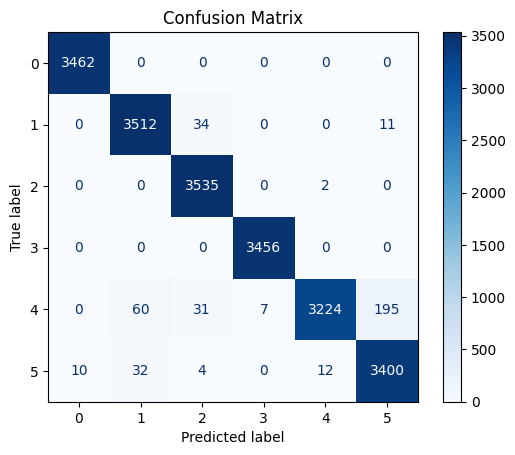

In [29]:
rf = RandomForestClassifier(criterion = 'gini',
                           max_depth = 20,
                           min_samples_split = 10,
                           random_state = 42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)


accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_val, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

print('Confusion Matrix')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # You can choose different colormaps
plt.title('Confusion Matrix')
plt.show()

In [30]:
# # Define the model
# dt = DecisionTreeClassifier()

# # Define the parameter grid
# param_grid = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'criterion': ['gini', 'entropy'],
#     'max_features': [None, 'auto', 'sqrt', 'log2']
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=1)

# # Fit the model
# grid_search.fit(x_train, y_train)

# # Best parameters
# print("Best parameters found: ", grid_search.best_params_)

# # Use the best model
# best_model = grid_search.best_estimator_

In [31]:
# # Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Make predictions using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_val)

# # Evaluate the model
# conf_matrix = confusion_matrix(y_val, y_pred)
# class_report = classification_report(y_val, y_pred)

# print("Best Parameters:", best_params)
# print("Best Cross-Validation Score:", best_score)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Cross-Validation Score: 0.978924611418795

Confusion Matrix:

 [[3462    0    0    0    0    0]
 
 [   0 3552    2    0    3    0]
 
 [   0    3 3533    1    0    0]
 
 [   0    0    0 3456    0    0]
 
 [   4   63   20   15 3258  157]
 
 [  17   27    1    0   62 3351]]
 
Classification Report:
                                precision    recall  f1-score   support

*        Crimes against Persons       0.99      1.00      1.00      3462
*   Crimes against Public Order       0.97      1.00      0.99      3557
* Fraud and White-Collar Crimes       0.99      1.00      1.00      3537
*                  Other Crimes       1.00      1.00      1.00      3456
*               Property Crimes       0.98      0.93      0.95      3517
*                Violent Crimes       0.96      0.97      0.96      3458
* 
*                      accuracy                           0.98     20987
*                     macro avg       0.98      0.98      0.98     20987
*                  weighted avg       0.98      0.98      0.98     20987

In [32]:
# dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = None,
#                              max_features= None, min_samples_leaf= 1,
#                              min_samples_split= 2)

# # Train the classifier
# dtc.fit(x_train, y_train)
# y_pred = dtc.predict(x_val)
# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy: {accuracy * 100:.2f}%')

# Conclusion: The DecisionTreeClassifier appears to be overfitting my dataset.

# **Overall Conclusion**


****When evaluating our models, RandomForestClassifier emerged as the top performer. LogisticRegression fell short, displaying signs of underfitting, while DecisionTreeClassifier exhibited overfitting tendencies. Thus, RandomForestClassifier proved to be the most balanced and effective choice.****

# Best Model: RandomForestClassifier

In [33]:
prediction = rf.predict(test)
submission = pd.DataFrame(columns = ['ID', 'Crime_Category'])
submission['ID'] = [i for i in range(1,len(prediction)+1)]
submission['Crime_Category'] = prediction
submission.to_csv('submission.csv', index = False)

In [34]:
submission.head

<bound method NDFrame.head of         ID                 Crime_Category
0        1                 Violent Crimes
1        2                Property Crimes
2        3  Fraud and White-Collar Crimes
3        4                Property Crimes
4        5    Crimes against Public Order
...    ...                            ...
4995  4996                Property Crimes
4996  4997                Property Crimes
4997  4998                 Violent Crimes
4998  4999                 Violent Crimes
4999  5000                Property Crimes

[5000 rows x 2 columns]>